In [1]:
# ─── Cell 1: SETUP & HISTORICAL PRICE PULL ─────────────────────────────────────
import yfinance as yf
import pandas as pd
import os

# 1. Define your asset universe (feel free to add/remove tickers)
tickers = ["SPY", "AGG", "TLT", "QQQ", "IWM"]

# 2. Download 5 years of daily Adjusted Close
prices = yf.download(
    tickers,
    period="5y",
    interval="1d",
    auto_adjust=False,   # we’ll use 'Adj Close' directly
    progress=False
)["Adj Close"]

# 3. Quick look
print("Price data shape:", prices.shape)
display(prices.head())

# 4. Save raw prices for later
os.makedirs("../data/processed", exist_ok=True)
prices.to_csv("../data/processed/prices.csv")
print("Saved prices to data/processed/prices.csv")


Price data shape: (1257, 5)


Ticker,AGG,IWM,QQQ,SPY,TLT
Date,,,,,
2020-04-27,102.464508,119.511581,209.189682,266.893158,146.715958
2020-04-28,102.867973,121.248909,205.249695,265.665741,148.404907
2020-04-29,102.938133,127.212288,212.528046,272.620575,147.634842
2020-04-30,102.710091,122.375877,212.440704,270.082245,145.910934
2020-05-01,102.715363,117.520630,206.453049,262.932281,147.160355


Saved prices to data/processed/prices.csv


In [2]:
# ─── Cell 2: DAILY RETURNS ─────────────────────────────────────────────────────
import numpy as np

# Load prices (if not already in the notebook)
prices = pd.read_csv("../data/processed/prices.csv", index_col=0, parse_dates=True)

# Compute daily returns and drop the first NaN
daily_ret = prices.pct_change().dropna()

print("Daily returns shape:", daily_ret.shape)
display(daily_ret.head())


Daily returns shape: (1256, 5)


,AGG,IWM,QQQ,SPY,TLT
Date,,,,,
2020-04-28,0.003938,0.014537,-0.018835,-0.004599,0.011512
2020-04-29,0.000682,0.049183,0.035461,0.026179,-0.005189
2020-04-30,-0.002215,-0.038018,-0.000411,-0.009311,-0.011677
2020-05-01,0.000051,-0.039675,-0.028185,-0.026473,0.008563
2020-05-04,0.000856,0.004315,0.011657,0.002758,-0.004704


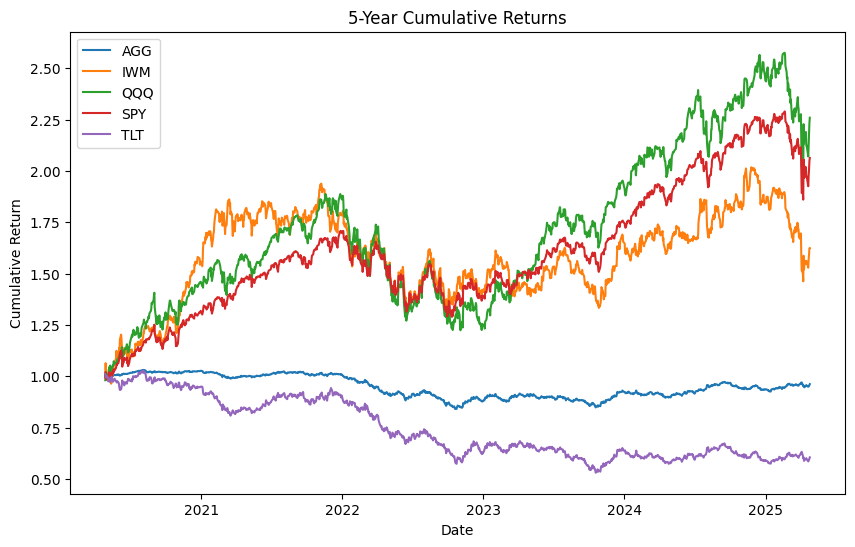

In [3]:
# ─── Cell 3: CUMULATIVE RETURNS PLOT ────────────────────────────────────────────
import matplotlib.pyplot as plt

cum_ret = (1 + daily_ret).cumprod()
plt.figure(figsize=(10, 6))
for ticker in cum_ret.columns:
    plt.plot(cum_ret.index, cum_ret[ticker], label=ticker)
plt.legend()
plt.title("5-Year Cumulative Returns")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.show()


In [4]:
# ─── Cell 4: MONTHLY RETURNS & STATISTICS ───────────────────────────────────────
# Resample to month-end prices and compute monthly returns
monthly_ret = prices.resample('M').ffill().pct_change().dropna()

# Compute statistics
mean_monthly = monthly_ret.mean()
cov_monthly  = monthly_ret.cov()

print("Monthly mean returns (%):")
print((mean_monthly * 100).round(2))

print("\nMonthly covariance matrix:")
display(cov_monthly)


Monthly mean returns (%):
AGG   -0.05
IWM    0.96
QQQ    1.51
SPY    1.30
TLT   -0.73
dtype: float64

Monthly covariance matrix:


/var/folders/44/w7p6wqzx45xc0d33d14kpptw0000gn/T/ipykernel_5965/3580080893.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_ret = prices.resample('M').ffill().pct_change().dropna()


,AGG,IWM,QQQ,SPY,TLT
AGG,0.000342,0.000600,0.000669,0.000533,0.000743
IWM,0.000600,0.003960,0.002667,0.002423,0.001161
QQQ,0.000669,0.002667,0.003504,0.002541,0.001411
SPY,0.000533,0.002423,0.002541,0.002175,0.001075
TLT,0.000743,0.001161,0.001411,0.001075,0.001864


Tangency portfolio weights:
  AGG: 1.706
  IWM: -0.256
  QQQ: 0.144
  SPY: 0.673
  TLT: -1.267


/var/folders/44/w7p6wqzx45xc0d33d14kpptw0000gn/T/ipykernel_5965/1059716483.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_ret  = prices.resample('M').ffill().pct_change().dropna()


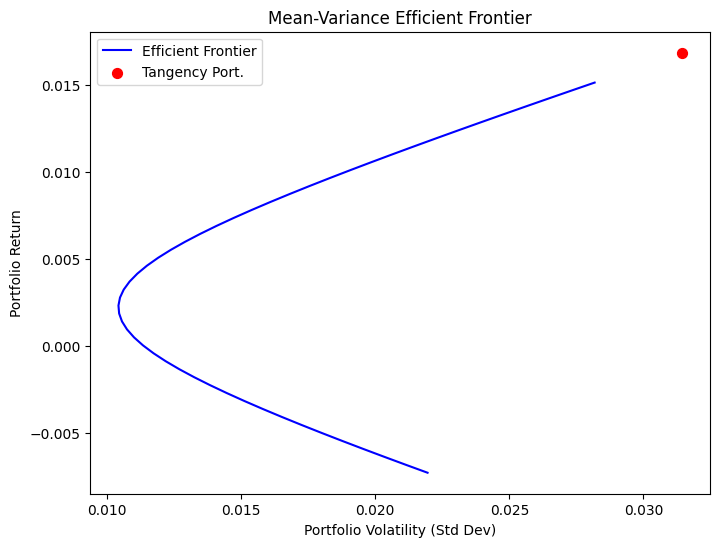

In [5]:
# ─── Cell 5: MARKOWITZ TANGENCY PORTFOLIO & FRONTIER ──────────────────────────
import numpy as np
import matplotlib.pyplot as plt

# 1. Load monthly returns & stats (if not in session)
prices       = pd.read_csv("../data/processed/prices.csv", index_col=0, parse_dates=True)
monthly_ret  = prices.resample('M').ffill().pct_change().dropna()
mu           = monthly_ret.mean()          # expected returns
Sigma        = monthly_ret.cov()           # covariance matrix

# 2. Risk-free rate (annual 0.5% → monthly)
r_f_annual   = 0.005
r_f          = (1 + r_f_annual)**(1/12) - 1

# 3. Precompute scalars for frontier
ones        = np.ones(len(mu))
invSigma    = np.linalg.inv(Sigma.values)
A           = ones @ invSigma @ ones
B           = ones @ invSigma @ mu.values
C           = mu.values @ invSigma @ mu.values
D           = A*C - B**2

# 4. Tangency weights
excess      = mu.values - r_f
w_tangency  = (invSigma @ excess) 
w_tangency /= w_tangency.sum()

print("Tangency portfolio weights:")
for t,w in zip(mu.index, w_tangency):
    print(f"  {t}: {w:.3f}")

# 5. Efficient frontier
target_rs   = np.linspace(mu.min(), mu.max(), 50)
fr_returns  = []
fr_risks    = []

for r_t in target_rs:
    a = (C - B*r_t) / D
    b = (A*r_t - B) / D
    w = a*(invSigma @ ones) + b*(invSigma @ mu.values)
    fr_returns.append(w @ mu.values)
    fr_risks.append(np.sqrt(w @ Sigma.values @ w))

# 6. Plot frontier
plt.figure(figsize=(8,6))
plt.plot(fr_risks, fr_returns, 'b-', label='Efficient Frontier')
# Mark tangency
tang_r = w_tangency @ mu.values
tang_s = np.sqrt(w_tangency @ Sigma.values @ w_tangency)
plt.scatter([tang_s], [tang_r], c='r', s=50, label='Tangency Port.')
plt.xlabel('Portfolio Volatility (Std Dev)')
plt.ylabel('Portfolio Return')
plt.title('Mean-Variance Efficient Frontier')
plt.legend()
plt.show()


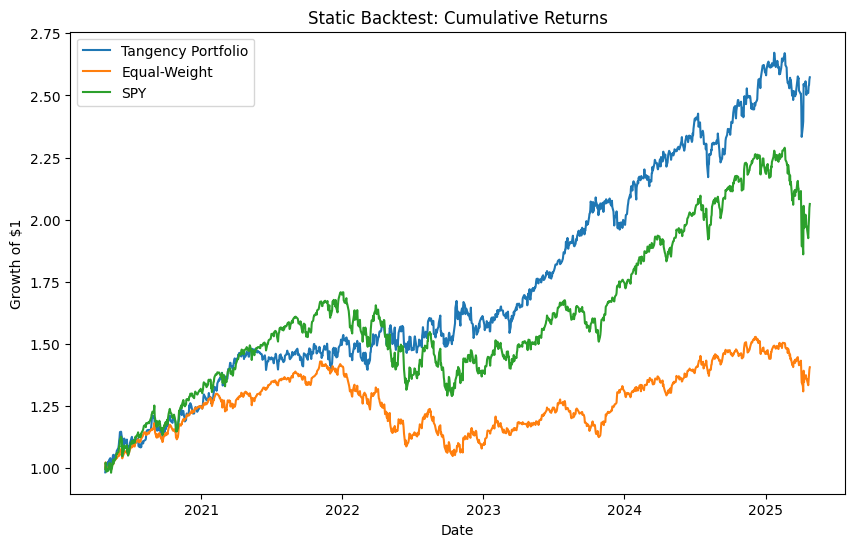

          Ann Return   Ann Vol    Sharpe  Max Drawdown
Tangency    0.226566  0.170839  1.296929      0.338866
EqualWgt    0.080422  0.134520  0.560678      0.380753
SPY         0.175290  0.180232  0.944839      0.429429


In [6]:
# ─── Cell 6: STATIC BACKTEST ───────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load daily returns (from Cell 2)
prices    = pd.read_csv("../data/processed/prices.csv", index_col=0, parse_dates=True)
daily_ret = prices.pct_change().dropna()

# 2. Define weights (in the same order as columns)
w = {
    'AGG':  1.706,
    'IWM': -0.256,
    'QQQ':  0.144,
    'SPY':  0.673,
    'TLT': -1.267
}

# 3. Compute portfolio returns
port_ret = daily_ret[list(w.keys())].mul(pd.Series(w), axis=1).sum(axis=1)

# 4. Build benchmarks
ew_ret  = daily_ret.mean(axis=1)          # equal-weight
spy_ret = daily_ret['SPY']                # SPY only

# 5. Cumulative returns
cum_port = (1 + port_ret).cumprod()
cum_ew   = (1 + ew_ret).cumprod()
cum_spy  = (1 + spy_ret).cumprod()

plt.figure(figsize=(10,6))
plt.plot(cum_port, label="Tangency Portfolio")
plt.plot(cum_ew,   label="Equal-Weight")
plt.plot(cum_spy,  label="SPY")
plt.legend()
plt.title("Static Backtest: Cumulative Returns")
plt.ylabel("Growth of $1")
plt.xlabel("Date")
plt.show()

# 6. Performance metrics
def perf_stats(returns):
    ann_ret = (1 + returns.mean())**252 - 1
    ann_vol = returns.std() * np.sqrt(252)
    sr      = (ann_ret - r_f_annual) / ann_vol
    dd      = ( (1+returns).cumprod() ).cummax() 
    mdd     = (dd - (1+returns).cumprod()).max()
    return ann_ret, ann_vol, sr, mdd

stats = pd.DataFrame({
    'Tangency': perf_stats(port_ret),
    'EqualWgt': perf_stats(ew_ret),
    'SPY':      perf_stats(spy_ret),
}, index=['Ann Return','Ann Vol','Sharpe','Max Drawdown']).T

print(stats)


In [8]:
# ─── Cell 7: LAGGED RETURNS FEATURE ENGINEERING ───────────────────────────────
import pandas as pd

# 1. Load monthly returns
prices      = pd.read_csv("../data/processed/prices.csv", index_col=0, parse_dates=True)
monthly_ret = prices.resample('ME').ffill().pct_change().dropna()   # use 'ME' for month-end

# 2. Build lagged return features for SPY only
df_feats = pd.DataFrame({
    'ret_lag_1': monthly_ret['SPY'].shift(1),
    'ret_lag_2': monthly_ret['SPY'].shift(2),
    'ret_lag_3': monthly_ret['SPY'].shift(3),
    'target_ret': monthly_ret['SPY'].shift(-1)  # next-month return
})

# 3. Drop NaNs
df_feats.dropna(inplace=True)

print("Feature matrix shape:", df_feats.shape)
display(df_feats.head())



Feature matrix shape: (56, 4)


,ret_lag_1,ret_lag_2,ret_lag_3,target_ret
Date,,,,
2020-08-31,0.058892,0.017734,0.047645,-0.037444
2020-09-30,0.069797,0.058892,0.017734,-0.024933
2020-10-31,-0.037444,0.069797,0.058892,0.108777
2020-11-30,-0.024933,-0.037444,0.069797,0.037048
2020-12-31,0.108777,-0.024933,-0.037444,-0.010191


In [9]:
# ─── Cell 8: TRAIN/TEST SPLIT & RANDOM FOREST REGRESSION ───────────────────────
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 1. Time-series split (first 80% train, last 20% test)
split = int(len(df_feats) * 0.8)
train = df_feats.iloc[:split]
test  = df_feats.iloc[split:]

X_train = train[['ret_lag_1','ret_lag_2','ret_lag_3']]
y_train = train['target_ret']
X_test  = test[['ret_lag_1','ret_lag_2','ret_lag_3']]
y_test  = test['target_ret']

# 2. Fit Random Forest regressor
rf_ret = RandomForestRegressor(n_estimators=100, random_state=42)
rf_ret.fit(X_train, y_train)

# 3. Predict & evaluate
y_pred     = rf_ret.predict(X_test)
mse        = mean_squared_error(y_test, y_pred)
dir_acc    = (np.sign(y_pred) == np.sign(y_test)).mean()

print(f"Test MSE:              {mse:.6f}")
print(f"Directional Accuracy:  {dir_acc:.2%}")


Test MSE:              0.001881
Directional Accuracy:  33.33%


In [10]:
# ─── Cell 9: AUGMENTED FEATURES FOR SPY RETURN FORECAST ───────────────────────
import pandas as pd
import numpy as np

# 1. Load monthly returns for all tickers
prices      = pd.read_csv("../data/processed/prices.csv", index_col=0, parse_dates=True)
monthly_ret = prices.resample('ME').ffill().pct_change().dropna()

# 2. Build a new features DataFrame
df_feats2 = pd.DataFrame(index=monthly_ret.index)

# 2a. Lagged SPY returns (1–3 months)
for i in range(1, 4):
    df_feats2[f"spy_ret_lag_{i}"] = monthly_ret['SPY'].shift(i)

# 2b. Cross-asset 1-month lag returns
for tkr in monthly_ret.columns:
    df_feats2[f"{tkr.lower()}_lag1"] = monthly_ret[tkr].shift(1)

# 2c. 3-month rolling vol and momentum on SPY
df_feats2['spy_vol_3m'] = monthly_ret['SPY'].rolling(3).std().shift(1)
df_feats2['spy_mom_3m'] = (1 + monthly_ret['SPY']).rolling(3).apply(np.prod).shift(1) - 1

# 2d. Target = next-month SPY return
df_feats2['target_ret'] = monthly_ret['SPY'].shift(-1)

# 3. Drop rows with any NaNs
df_feats2.dropna(inplace=True)

print("Augmented feature matrix shape:", df_feats2.shape)
display(df_feats2.head())


Augmented feature matrix shape: (56, 11)


,spy_ret_lag_1,spy_ret_lag_2,spy_ret_lag_3,agg_lag1,iwm_lag1,qqq_lag1,spy_lag1,tlt_lag1,spy_vol_3m,spy_mom_3m,target_ret
Date,,,,,,,,,,,
2020-08-31,0.058892,0.017734,0.047645,0.013332,0.029194,0.073465,0.058892,0.044351,0.021272,0.129017,-0.037444
2020-09-30,0.069797,0.058892,0.017734,-0.008236,0.054764,0.109448,0.069797,-0.050465,0.027457,0.152889,-0.024933
2020-10-31,-0.037444,0.069797,0.058892,-0.000973,-0.032613,-0.057786,-0.037444,0.007734,0.059020,0.090383,0.108777
2020-11-30,-0.024933,-0.037444,0.069797,-0.005583,0.022031,-0.030449,-0.024933,-0.033852,0.058638,0.004065,0.037048
2020-12-31,0.108777,-0.024933,-0.037444,0.012068,0.182442,0.112258,0.108777,0.016639,0.081051,0.040650,-0.010191


In [11]:
# ─── Cell 10: AUGMENTED RF REGRESSION ───────────────────────────────────────────
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 1. Rebuild the augmented feature set (mirror Cell 9)
prices      = pd.read_csv("../data/processed/prices.csv", index_col=0, parse_dates=True)
monthly_ret = prices.resample('ME').ffill().pct_change().dropna()

df_feats2 = pd.DataFrame(index=monthly_ret.index)
# SPY lagged returns
for i in range(1, 4):
    df_feats2[f"spy_ret_lag_{i}"] = monthly_ret['SPY'].shift(i)
# Cross-asset 1-month lag returns
for tkr in monthly_ret.columns:
    df_feats2[f"{tkr.lower()}_lag1"] = monthly_ret[tkr].shift(1)
# Rolling volatility & momentum
df_feats2['spy_vol_3m'] = monthly_ret['SPY'].rolling(3).std().shift(1)
df_feats2['spy_mom_3m'] = (1 + monthly_ret['SPY']).rolling(3).apply(np.prod).shift(1) - 1
# Next-month target
df_feats2['target_ret'] = monthly_ret['SPY'].shift(-1)
df_feats2.dropna(inplace=True)

# 2. Train/test split (first 80% train, last 20% test)
split = int(len(df_feats2) * 0.8)
train2 = df_feats2.iloc[:split]
test2  = df_feats2.iloc[split:]

X_train2 = train2.drop(columns='target_ret')
y_train2 = train2['target_ret']
X_test2  = test2.drop(columns='target_ret')
y_test2  = test2['target_ret']

# 3. Fit RF regressor
rf2 = RandomForestRegressor(n_estimators=100, random_state=42)
rf2.fit(X_train2, y_train2)

# 4. Evaluate
y_pred2  = rf2.predict(X_test2)
mse2     = mean_squared_error(y_test2, y_pred2)
dir_acc2 = (np.sign(y_pred2) == np.sign(y_test2)).mean()

print(f"Augmented RF Test MSE: {mse2:.6f}")
print(f"Augmented RF Directional Accuracy: {dir_acc2:.2%}")


Augmented RF Test MSE: 0.001558
Augmented RF Directional Accuracy: 41.67%


In [15]:
# ─── Cell 11: PREPARE LSTM DATA ───────────────────────────────────────────────
import pandas as pd
import numpy as np

# 1. Load monthly SPY returns
prices = pd.read_csv("../data/processed/prices.csv", index_col=0, parse_dates=True)
monthly_spy = prices['SPY'].resample('ME').ffill().pct_change().dropna()

# 2. Build sliding windows of length 3 to predict next return
seq_len = 3
X_seq, y_seq = [], []
for i in range(seq_len, len(monthly_spy)):
    window = monthly_spy.values[i-seq_len:i].reshape(seq_len, 1)
    X_seq.append(window)
    y_seq.append(monthly_spy.values[i])

X_seq = np.array(X_seq)  # shape (n_samples, 3, 1)
y_seq = np.array(y_seq)

# 3. Split into train/test (first 80% train, last 20% test)
split_idx = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_test_seq = y_seq[:split_idx], y_seq[split_idx:]

print("Sequence data shapes →",
      "X_train:", X_train_seq.shape,
      "X_test:", X_test_seq.shape,
      "y_train:", y_train_seq.shape,
      "y_test:", y_test_seq.shape)


Sequence data shapes → X_train: (45, 3, 1) X_test: (12, 3, 1) y_train: (45,) y_test: (12,)


In [16]:
# ─── Cell 12: BUILD & TRAIN LSTM ─────────────────────────────────────────────
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# 1. Define a simple LSTM model
model = Sequential([
    LSTM(32, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# 2. Train (you can adjust epochs/batch_size)
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50,
    batch_size=16,
    verbose=1
)

# 3. Predict & compute metrics
y_pred_lstm = model.predict(X_test_seq).flatten()
mse_lstm = mean_squared_error(y_test_seq, y_pred_lstm)
dir_acc_lstm = np.mean(np.sign(y_pred_lstm) == np.sign(y_test_seq))

print(f"LSTM Test MSE:              {mse_lstm:.6f}")
print(f"LSTM Directional Accuracy:  {dir_acc_lstm:.2%}")


Epoch 1/50


/Users/yessir/Desktop/Recent_fintech_platform_project/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0027 - val_loss: 0.0010
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0027 - val_loss: 0.0010
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0024 - val_loss: 0.0010
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0023 - val_loss: 0.0010
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0023 - val_loss: 0.0010
Epoch 13/50


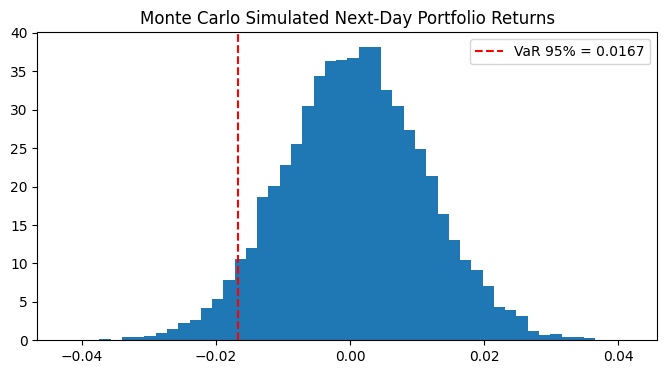

Estimated 1-Day 95% VaR: 0.0167


In [17]:
# ─── Cell 13: MONTE CARLO SIMULATION & VaR ────────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load daily returns
prices     = pd.read_csv("../data/processed/prices.csv", index_col=0, parse_dates=True)
daily_ret  = prices.pct_change().dropna()

# 2. Tangency weights from earlier (AGG, IWM, QQQ, SPY, TLT)
weights = np.array([1.706, -0.256, 0.144, 0.673, -1.267])

# 3. Historical portfolio returns
port_ret = daily_ret.dot(weights)

# 4. Estimate mean & std
mu_hist    = port_ret.mean()
sigma_hist = port_ret.std()

# 5. Monte Carlo sim for next-day returns
n_sims     = 10000
sim_rets   = np.random.normal(mu_hist, sigma_hist, n_sims)

# 6. Compute 95% VaR
VaR_95 = -np.percentile(sim_rets, 5)

# 7. Plot (optional)
plt.figure(figsize=(8,4))
plt.hist(sim_rets, bins=50, density=True)
plt.axvline(-VaR_95, color='r', linestyle='--', label=f'VaR 95% = {VaR_95:.4f}')
plt.title("Monte Carlo Simulated Next-Day Portfolio Returns")
plt.legend()
plt.show()

print(f"Estimated 1-Day 95% VaR: {VaR_95:.4f}")
